In [1]:
!pip install yfinance
!pip install pandas_ta
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

import pickle

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

     |████████████████████████████████| 6.4 MB 8.5 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 115 kB 8.6 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=934d1317a2bf58d523366a4c4571843b52cb4295a855b7ce311bf19856af314

In [2]:
# Load silver price
df = yf.Ticker("SI=F")
data = df.history(period="max")
data.drop([column for column in data.columns if column not in ['Open','Close', 'High', 'Low']], axis=1, inplace=True)

In [3]:
data.head()

,Open,High,Low,Close
Date,,,,
2000-08-30,4.950,4.950,4.895,4.930
2000-08-31,4.920,5.045,4.920,5.003
2000-09-01,5.035,5.035,4.985,5.004
2000-09-05,4.990,5.005,4.975,4.998
2000-09-06,5.000,5.000,4.980,4.983


In [4]:
chart = yf.Ticker("SI=F").history(period="2y")
fig = go.Figure(data=[go.Candlestick(x=chart.index,
                open=chart['Open'],
                high=chart['High'],
                low=chart['Low'],
                close=chart['Close'])])

fig.show()

In [5]:
# Add gold price
df = yf.Ticker("GC=F")
gold = df.history(period="max")
data['Gold'] = gold['Close']

In [6]:
data.isna().sum()

Open     0
High     0
Low      0
Close    0
Gold     3
dtype: int64

In [7]:
data['Gold'].fillna(method='ffill', inplace=True)

In [8]:
data.isna().sum()

Open     0
High     0
Low      0
Close    0
Gold     0
dtype: int64

In [9]:
data.tail()

,Open,High,Low,Close,Gold
Date,,,,,
2022-04-22,24.725000,24.725000,24.215000,24.257000,1931.000000
2022-04-25,23.667999,23.667999,23.667999,23.667999,1893.199951
2022-04-26,23.542000,23.594999,23.542000,23.542000,1901.400024
2022-04-27,23.458000,23.458000,23.458000,23.458000,1885.900024
2022-04-28,23.309999,23.270000,23.209999,23.165001,1896.500000


In [10]:
# Add Silver and Gold price change 10, 30, 100 days in percentage points
windows = [10, 30, 100]
for window in windows:
    data["Silver_"+str(window)] = data['Close'].rolling(window+1).apply(lambda x: (x.iloc[window] - x.iloc[0]) / x.iloc[0] * 100)
    data["Gold_"+str(window)] = data['Gold'].rolling(window+1).apply(lambda x: (x.iloc[window] - x.iloc[0]) / x.iloc[0] * 100)

In [11]:
data.tail()

,Open,High,Low,Close,Gold,Silver_10,Gold_10,Silver_30,Gold_30,Silver_100,Gold_100
Date,,,,,,,,,,,
2022-04-22,24.725000,24.725000,24.215000,24.257000,1931.000000,-1.924554,-0.144795,-7.423096,-3.358189,6.395018,8.343149
2022-04-25,23.667999,23.667999,23.667999,23.667999,1893.199951,-4.637580,-2.492791,-9.338855,-4.514047,3.966615,6.743346
2022-04-26,23.542000,23.594999,23.542000,23.542000,1901.400024,-5.749062,-2.206451,-6.742195,-2.969991,5.574241,6.724296
2022-04-27,23.458000,23.458000,23.458000,23.458000,1885.900024,-8.812440,-4.370973,-6.627389,-2.208969,5.287251,7.110813
2022-04-28,23.309999,23.270000,23.209999,23.165001,1896.500000,-10.972327,-4.265522,-6.100524,-0.602725,3.207847,6.425365


In [12]:
# Add technical indicators RSI, MACD and Stochastic Oscillator for Silver
data['RSI_14']=ta.rsi(data['Close'],lenght=14)

MACD = ta.macd(data['Close'],fast=12, slow=26, signal=9)
data = pd.concat([data,MACD],axis=1)

STOCH = ta.stoch(high=data.High,low=data.Low,close=data.Close)
data = pd.concat([data, STOCH], axis=1)

In [13]:
data.tail()

,Open,High,Low,Close,Gold,Silver_10,Gold_10,Silver_30,Gold_30,Silver_100,Gold_100,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,STOCHk_14_3_3,STOCHd_14_3_3
Date,,,,,,,,,,,,,,,,,
2022-04-22,24.725000,24.725000,24.215000,24.257000,1931.000000,-1.924554,-0.144795,-7.423096,-3.358189,6.395018,8.343149,41.698991,0.017412,-0.090416,0.107827,23.153213,45.020230
2022-04-25,23.667999,23.667999,23.667999,23.667999,1893.199951,-4.637580,-2.492791,-9.338855,-4.514047,3.966615,6.743346,37.232059,-0.097874,-0.164561,0.066687,5.930978,23.657706
2022-04-26,23.542000,23.594999,23.542000,23.542000,1901.400024,-5.749062,-2.206451,-6.742195,-2.969991,5.574241,6.724296,36.335352,-0.197133,-0.211056,0.013923,0.727270,9.937154
2022-04-27,23.458000,23.458000,23.458000,23.458000,1885.900024,-8.812440,-4.370973,-6.627389,-2.208969,5.287251,7.110813,35.717747,-0.279355,-0.234622,-0.044733,0.000000,2.219416
2022-04-28,23.309999,23.270000,23.209999,23.165001,1896.500000,-10.972327,-4.265522,-6.100524,-0.602725,3.207847,6.425365,33.574069,-0.363963,-0.255384,-0.108579,-0.511925,0.071782


In [14]:
# Prepare the target - Silver price direction change over next window days
window = 10
data['Target'] = data['Close'].rolling(window + 1).apply(lambda x: x.iloc[window] > x.iloc[0]) 

In [15]:
# We want to know the future outcome pre-fact to train our model
data['Target'] = data['Target'].shift(-window)

In [16]:
data.shape

(5436, 18)

In [17]:
data.isna().sum()

Open               0
High               0
Low                0
Close              0
Gold               0
Silver_10         10
Gold_10           10
Silver_30         30
Gold_30           30
Silver_100       100
Gold_100         100
RSI_14            14
MACD_12_26_9      25
MACDh_12_26_9     33
MACDs_12_26_9     33
STOCHk_14_3_3     15
STOCHd_14_3_3     17
Target            10
dtype: int64

In [18]:
# Remove first 100 rows (missing values for technical indicators) and last 10 rows (missing Target)
data.dropna(axis=0, inplace=True)
data.isna().sum().sum()

0

In [19]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Gold', 'Silver_10', 'Gold_10',
       'Silver_30', 'Gold_30', 'Silver_100', 'Gold_100', 'RSI_14',
       'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'STOCHk_14_3_3',
       'STOCHd_14_3_3', 'Target'],
      dtype='object')

In [20]:
# We can remove first 5 columns, as we are not interested in present nominal values
data.drop(['Open','High','Low','Close','Gold'], axis=1, inplace=True)

In [21]:
# Saving copy of clean data
data.to_csv('data.csv')
data_for_backtest = data.iloc[int(data.shape[0]*0.8):]
data = data.iloc[:int(data.shape[0]*0.8)]

In [22]:
data_for_backtest.to_csv('data_bt.csv')

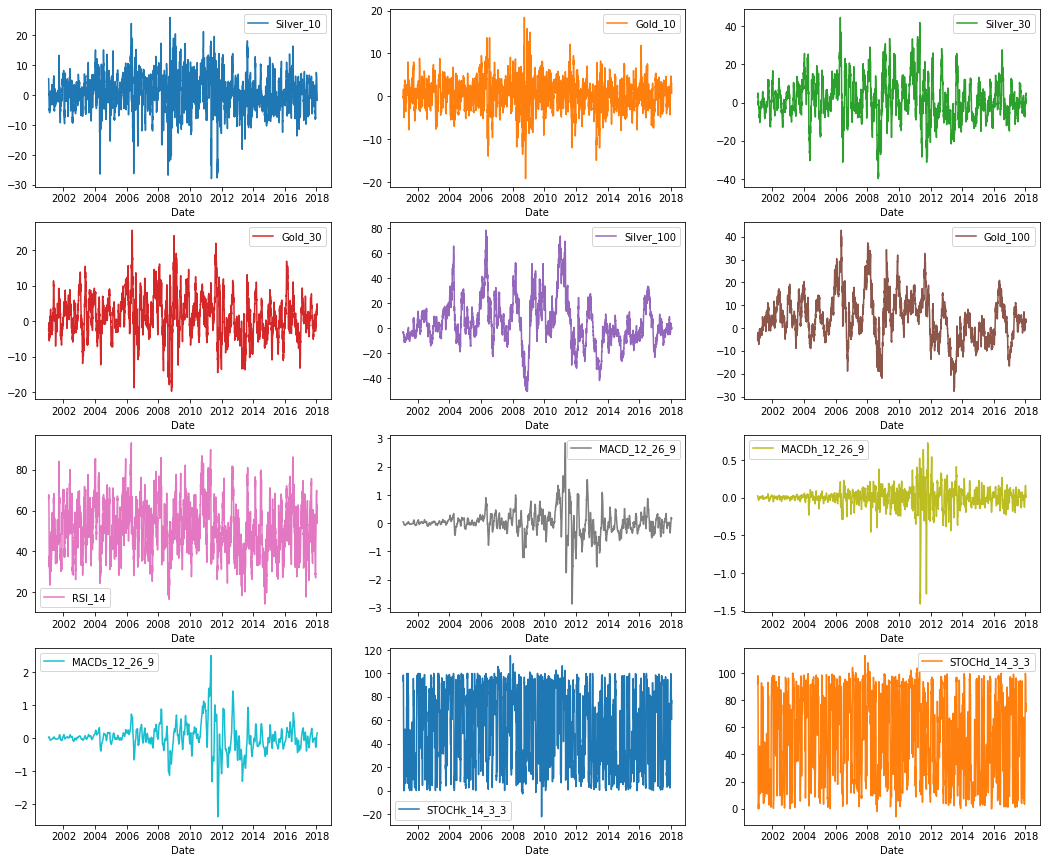

In [23]:
features = data[[column for column in data.columns if column !='Target']]
features.plot(subplots=True, sharex=False, layout=(4,3), figsize=(18,15))
plt.show()

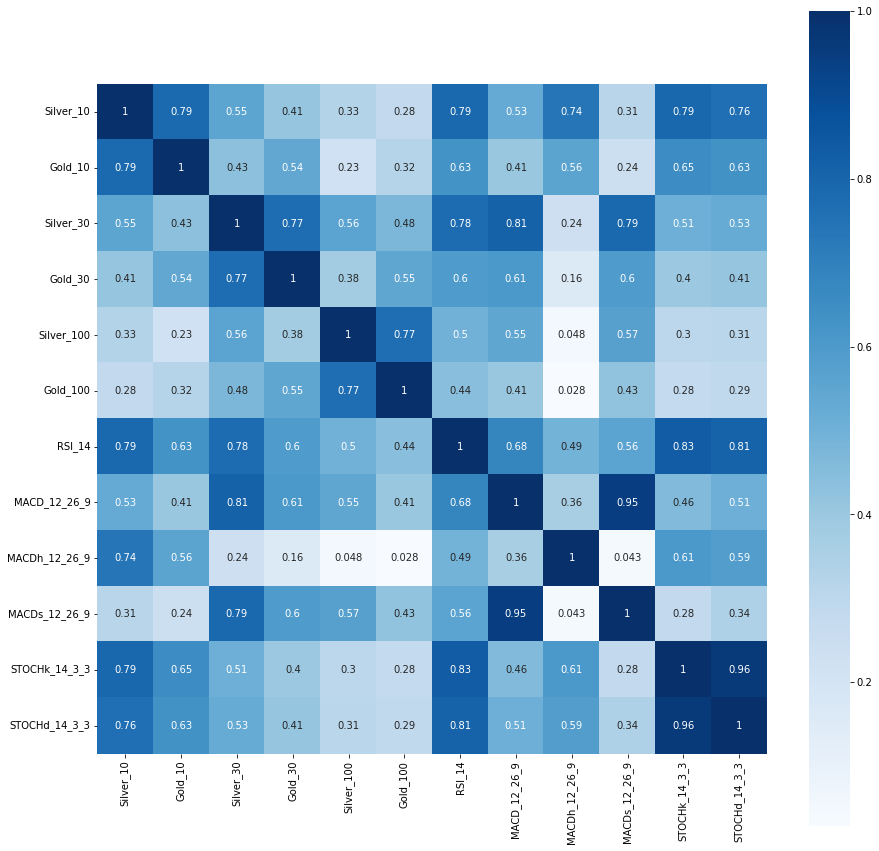

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(features.corr(),square=True,cmap="Blues",annot=True)
plt.show()

In [24]:
target = data['Target']

In [ ]:
target.value_counts()

1.0    2310
0.0    1950
Name: Target, dtype: int64

In [ ]:
target.value_counts(normalize=True)

1.0    0.542254
0.0    0.457746
Name: Target, dtype: float64

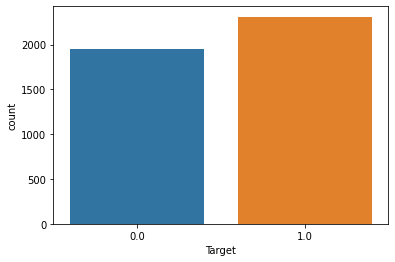

In [ ]:
ax = sns.countplot(target)
plt.show()

54% of the ten-day periods were up for silver. 54% of the ten-day periods were up for silver. This means that a naive algorithm that always forecasts price increases would have 54% accuracy. We will try to beat this result.

For model selection, we will select the most promising models taking into account our previous projects and financial literature.


In [ ]:
models = []
models.append(('RF', RandomForestClassifier()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('GRAD', GradientBoostingClassifier()))

In [ ]:
# Not good for time series!
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=9)
# X_train = features.iloc[:int(features.shape[0]*0.8)]
# X_test = features.iloc[int(features.shape[0]*0.8):]
# y_train = target.iloc[:int(target.shape[0]*0.8)]
# y_test = target.iloc[int(target.shape[0]*0.8):]

In [ ]:
X_train.tail()

,Silver_10,Gold_10,Silver_30,Gold_30,Silver_100,Gold_100,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,STOCHk_14_3_3,STOCHd_14_3_3
Date,,,,,,,,,,,,
2016-05-09,0.382244,2.155134,12.346975,3.746205,24.908527,18.869168,56.162114,0.436170,-0.043628,0.479798,43.037903,54.858606
2005-09-07,1.278372,1.251707,0.829402,5.077941,-2.354246,3.633824,54.709023,-0.032866,0.022210,-0.055076,89.163508,78.307930
2008-03-24,-15.333869,-5.544129,1.983859,1.346431,20.088654,17.145039,36.075965,0.131835,-0.457338,0.589174,4.153395,17.369574
2003-01-30,1.992445,5.104076,3.424070,9.376856,7.707643,15.839092,56.475887,0.038305,-0.005617,0.043921,73.497282,71.063340
2002-08-08,-4.452682,0.193675,-4.017390,-3.060593,3.413663,7.071404,37.614162,-0.082449,-0.017999,-0.064450,11.794333,9.696042


In [ ]:
y_test.head()

Date
2014-06-25    1.0
2007-04-11    0.0
2009-07-24    1.0
2014-03-03    0.0
2015-08-26    1.0
Name: Target, dtype: float64

In [ ]:
results = []
names = []
for name, model in models:
    results.append(cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy'))
    names.append(name)

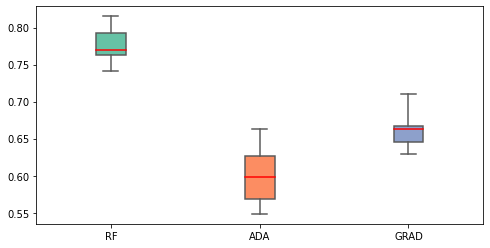

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(ax=ax, data=results, orient='v',  palette="Set2", saturation=1, width=0.2, whis=5, medianprops=dict(color="red", alpha=1))
ax.set_xticklabels(names)
plt.show()

In [ ]:
n_estimators = range(10,150,10)
params = {
    'n_estimators': n_estimators,
    }

In [ ]:
grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params, scoring='accuracy', cv=10)

In [ ]:
results = grid.fit(X_train, y_train)

In [ ]:
print(results.best_params_)
print(results.best_score_)

{'n_estimators': 130}
0.7828601000517509


Text(0, 0.5, 'Accuracy')

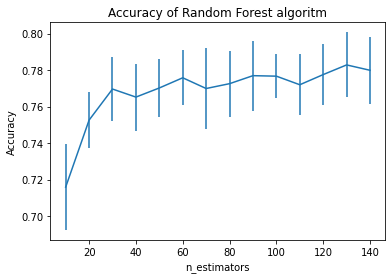

In [ ]:
means = results.cv_results_['mean_test_score']
stds = results.cv_results_['std_test_score']
params = results.cv_results_['params']
plt.errorbar(n_estimators, means, yerr=stds)
plt.title("Accuracy of Random Forest algoritm")
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

It seems that without changing other parameters, we achieve the highest accuracy of 0.78 with n_estimators = 130. Let's try to optimize the remaining parameters.

In [ ]:
params = {
     'n_estimators': [130],
     'bootstrap': [True, False],
     'max_features': ['auto', 'sqrt'],
     'min_samples_split' : [2, 4],
     'min_samples_leaf' : [1, 2],
     'criterion' : ["gini","entropy"]
     }

In [ ]:
grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params, scoring='accuracy', cv=10)
# Computing time ~ 16 mins
results = grid.fit(X_train, y_train)
print(results.best_params_)
print(results.best_score_)

{'bootstrap': False, 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 130}
0.7978221493876142


In [ ]:
max_depth = range(5,25,1)
max_depth_series = []
accuracy_score_series = []
for max_d in max_depth:
  model = RandomForestClassifier(criterion='gini', bootstrap=False, max_depth=max_d, max_features='auto', min_samples_leaf=2, min_samples_split=4, n_estimators=130)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  max_depth_series.append(max_d)
  accuracy_score_series.append(accuracy_score(y_test,y_pred))

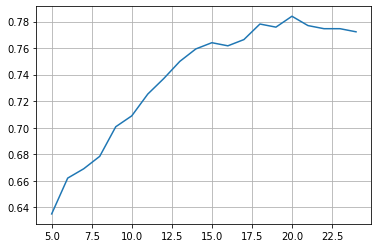

In [ ]:
sns.lineplot(x=max_depth_series, y=accuracy_score_series)
plt.grid()
plt.show()

We can observe that a max_depth parameter above 20 does not further increase the accuracy of the model.

### Forum post by Andy Liaw, who maintains the randomForest package in R:

"For the most part, performance on training set is meaningless. (That's the case for most algorithms, but especially so for RF.) In the default (and recommended) setting, the trees are grown to the maximum size, which means that quite likely there's only one data point in most terminal nodes, and the prediction at the terminal nodes are determined by the majority class in the node, or the lone data point. Suppose that is the case all the time; i.e., in all trees all terminal nodes have only one data point. A particular data point would be "in-bag" in about 64% of the trees in the forest, and every one of those trees has the correct prediction for that data point. Even if all the trees where that data points are out-of-bag gave the wrong prediction, by majority vote of all trees, you still get the right answer in the end. Thus basically the perfect prediction on train set for RF is "by design"."

In [ ]:
model = RandomForestClassifier(criterion='gini', bootstrap=False, max_depth=20, max_features='auto', min_samples_leaf=2, min_samples_split=4, n_estimators=130)

In [ ]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_leaf=2,
                       min_samples_split=4, n_estimators=130)

In [ ]:
# What is an accuracy on the test sample?
y_pred = model.predict(X_test)
accuracy_score(y_test,y_pred)

0.7758215962441315

We would like to see the confusion matrix, which may contain valuable tips for the construction of our investment strategy. Namely, do we want to include both long and short positions, or only long?

In [ ]:
y_pred[y_pred==1].shape

(492,)

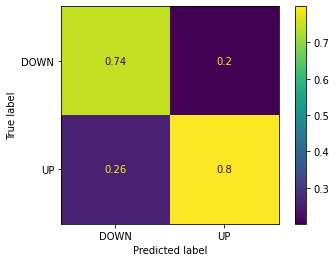

In [ ]:
# Add confusion matrix
cm = confusion_matrix(y_test, y_pred,normalize='pred')
cmd = ConfusionMatrixDisplay(cm, display_labels=['DOWN','UP'])
cmd.plot()
plt.show()

Conclusion: model has a slightly better effectiveness in predicting ups than downs. This information can be useful when building a bot strategy.

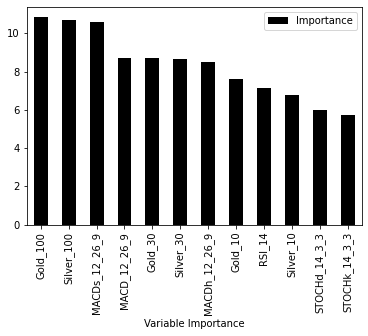

In [ ]:
# Add features importance
imp = pd.DataFrame({'Importance':model.feature_importances_*100}, index=features.columns)
imp.sort_values('Importance', axis=0, ascending=False).plot(kind='bar', color='k')
plt.xlabel('Variable Importance')
plt.show()

We can observe that all the variables are quite important and have an influence on the functioning of the model.

In [ ]:
pickle.dump(model, open('model.sav', 'wb'))

# Backtesting

In [34]:
model = pickle.load(open('model.sav', 'rb'))

In [35]:
data = pd.read_csv('data_bt.csv', index_col='Date')

In [36]:
data.index = data.index.astype('datetime64[ns]')

In [37]:
silver_price = yf.Ticker("SI=F").history(period='max')['Close']

In [38]:
data = pd.concat((data, silver_price), axis=1, join='inner')

In [39]:
data.tail()

,Silver_10,Gold_10,Silver_30,Gold_30,Silver_100,Gold_100,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,STOCHk_14_3_3,STOCHd_14_3_3,Target,Close
Date,,,,,,,,,,,,,,
2022-04-07,-4.505791,-1.417207,0.190387,0.451928,-2.410827,3.528027,48.260228,-0.038492,-0.134949,0.096456,18.538042,17.816795,0.0,24.733000
2022-04-08,-3.031839,-0.624428,3.425430,2.920751,-1.147091,4.045871,49.239449,-0.038792,-0.108198,0.069407,24.210561,19.460720,0.0,24.819000
2022-04-11,-0.786463,0.242322,2.532739,2.363906,0.136307,4.893185,51.082768,-0.025900,-0.076245,0.050345,34.405501,25.718035,0.0,24.978001
2022-04-12,4.082379,3.143304,0.748022,1.529034,2.217191,5.476816,58.675361,0.044085,-0.005008,0.049093,53.742733,37.452931,0.0,25.725000
2022-04-13,3.652949,2.456685,3.323670,3.128740,4.493801,6.448146,61.234313,0.121947,0.058283,0.063664,75.987753,54.711995,0.0,26.020000


In [40]:
data['Prediction'] = model.predict(data.drop(['Target', 'Close'],axis=1))


In [41]:
series=data['Prediction']==data['Target']
series.value_counts()

True     570
False    496
dtype: int64

In [42]:
accuracy_score(data['Target'], data['Prediction'], normalize=True)

0.5347091932457786

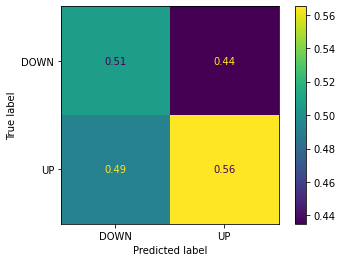

In [43]:
cm = confusion_matrix(data['Target'], data['Prediction'],normalize='pred')
cmd = ConfusionMatrixDisplay(cm, display_labels=['DOWN','UP'])
cmd.plot()
plt.show()

As the results of the model are not that spectacular on the 'out of sample', let's try to build a strategy that will consist in buying silver when we receive a positive signal from the model. As you can see in the confusion matrix, in the case of short sales, we have no advantage over random selection.

In [47]:
CAGR_bah = ((data['Close'][-1] / data['Close'][0]) ** (1/years_delta) - 1)
CAGR_bah

0.10624711467270043

In [50]:
std_bah = data['Close'].std()
std_bah

sharp_bah = (CAGR_bah - risk_free) / std_bah
sharp_bah

0.018656340580946916

In [70]:
def sharpe_ratio(price_series, N, risk_free):
    return_series = []
    for i in range(len(price_series)-1):
      return_series.append((price_series[i+1]-price_series[i])/price_series[i])
    mean = np.mean(return_series) * N -risk_free
    sigma = np.std(return_series) * np.sqrt(N)
    return mean / sigma

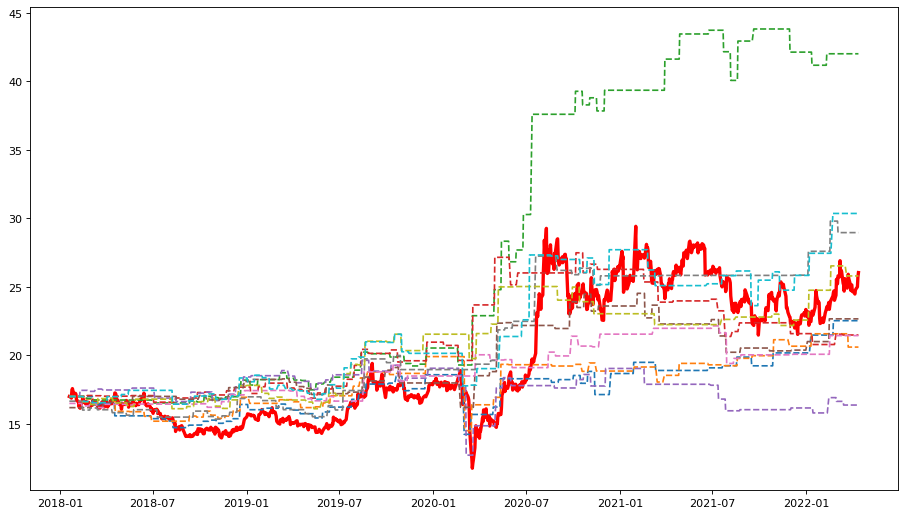

Sharpe ratio of strategy:  0.496
Sharpe ratio buy & hold: 0.396
CAGR of strategy:  0.096
CAGR buy & hold:  0.098


In [96]:
CAGR_strat = []
CAGR_bh = []
sharpe_ratio_strat = []
sharpe_ratio_bh = []
risk_free = 0.02
plt.figure(figsize=(14, 8), dpi=80)
plt.plot(data['Close'],c='r', linewidth=3)

for starting_day in range (0,10):
    day=starting_day
    capital_history = []
    data['Capital'] = np.nan
    capital = data['Close'][0]
    trades_count = 0

    while day < len(data.index)-10:

        if data['Prediction'][day] == 1:
            capital += capital * (data['Close'][day+10] - data['Close'][day]) / data['Close'][day]
            trades_count += 1
        else:
            pass

        data['Capital'].iloc[day] = capital
        capital_history.append(capital)
        day += 10
        
    data['Capital'].fillna(method='ffill', inplace=True)
    data['Capital'].fillna(method='bfill', inplace=True)
    
    plt.plot(data['Capital'],ls='--')
     
    years_delta = (data.index[day-10] - data.index[starting_day]).days / 365.2425
    CAGR_strat.append((data['Capital'][day-10] / data['Capital'][starting_day]) ** (1/years_delta) - 1)
    CAGR_bh.append((data['Close'][day-10] / data['Close'][starting_day]) ** (1/years_delta) - 1)
    sharpe_ratio_strat.append(sharpe_ratio(data['Capital'][starting_day:day-10],255,risk_free))
    sharpe_ratio_bh.append(sharpe_ratio(data['Close'][starting_day:day-10],255,risk_free))

plt.show()
print('Sharpe ratio of strategy: ', round(np.mean(sharpe_ratio_strat),3))
print('Sharpe ratio buy & hold:', round(np.mean(sharpe_ratio_bh),3))
print('CAGR of strategy: ', round(np.mean(CAGR_strat),3))
print('CAGR buy & hold: ', round(np.mean(CAGR_bh),3))

**Conclusions**:<br>
The model-based strategy has a higher Sharpe ratio, which means it delivers better risk-adjusted returns. The model can therefore be used in practice when building an investment portfolio.<br>The weak point of the strategy is that it is very sensitive to when it starts beeing aplied. The solution to this problem may be to divide the capital into N equal parts and execute the strategy every 10/N day.